# Pilot data analysis

We extracted the data from the logs in the notebook `create_dataset.ipynb`.

In [2]:
from utils import *

In [3]:
df = pd.read_csv('pilot_1.csv', index_col=0)

# Models vs. Time
We can plot the number of models recorded during the pilot, for each condition and participant independently.

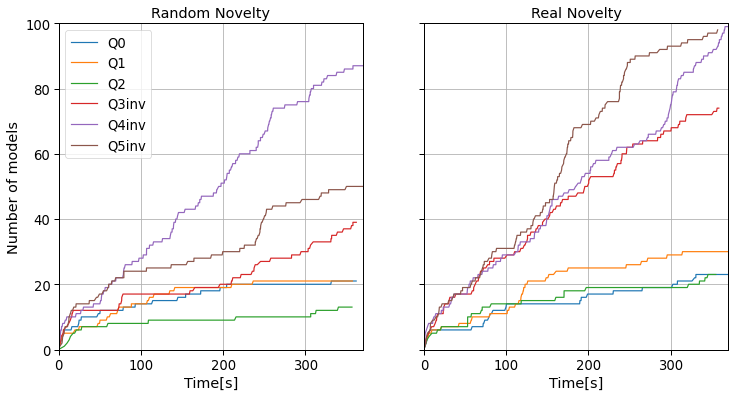

In [118]:
sns.set_context('paper', font_scale=1.5)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, grp in select(df, condition='c1').groupby('user'):
    grp['then'] -= grp['then'].iloc[0]
    # grp['then'] = pd.to_datetime(grp['then'], unit='ms').dt.time 
    grp['then'] /= 1000 
    grp.plot('then', 'length', ax=axs[0], label=i)
    
for i, grp in select(df, condition='c2').groupby('user'):
    grp['then'] -= grp['then'].iloc[0]
    # grp['then'] = pd.to_datetime(grp['then'], unit='ms').dt.time 
    grp['then'] /= 1000
    grp.plot('then', 'length', ax=axs[1], label=i)

axs[0].set_title('Random Novelty')
axs[1].set_title('Real Novelty')

for ax in axs:
    ax.set_xlim([0, 370])
    ax.set_ylim([0, 100])
    ax.set_xlabel('Time[s]')
    ax.set_ylabel('Number of models')
    ax.grid()

axs[1].get_legend().remove()
axs[1].set_ylabel('')
axs[1].set_yticklabels([]);

if True:
    fig.savefig('fig/model_time.png')
    fig.savefig('fig/model_time.pdf')

Note that plotting with a dataframe can also be done in a more compact manner with seaborn and FacetGrid.

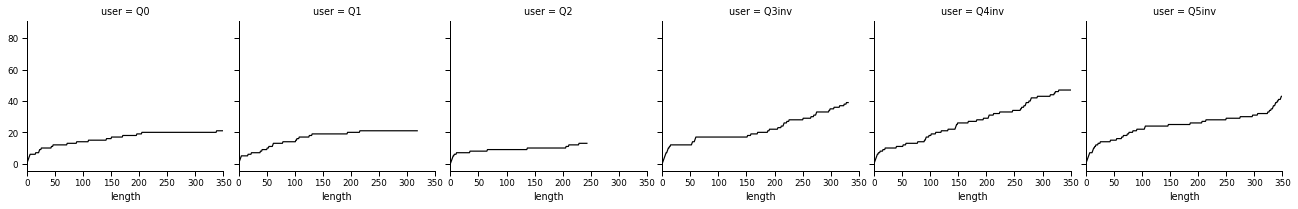

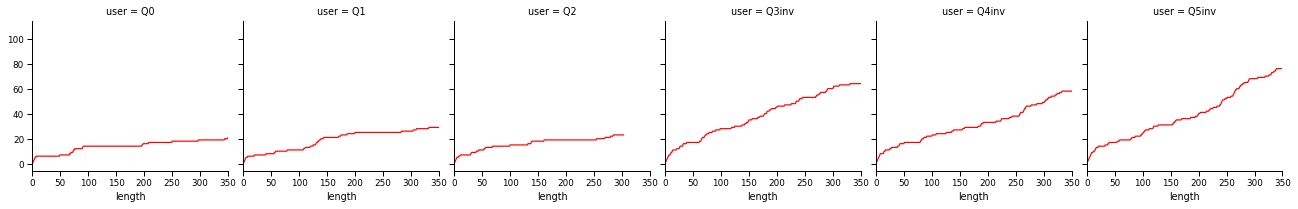

In [24]:
sns.set_context("paper", font_scale=1)
grid = sns.FacetGrid(select(df, condition='c1'), col='user', col_wrap=6)
grid.map(plt.plot, 'length', color='k')
grid.set(xlim=(0, 350))

grid = sns.FacetGrid(select(df, condition='c2'), col='user', col_wrap=6)
grid.map(plt.plot, 'length', color='r')
grid.set(xlim=(0, 350))

# Difference in Number of Models

In [54]:
# dataframe of user id to [ max. reached model for c1, for c2, delta, improvement factor ]
maxmodel = pd.DataFrame(columns=['user', 'numc1', 'numc2', 'diff', 'factor'])

for p, grp in select(df, condition='c1').groupby('user'):
    maxmodel.loc[p] = [ p, list(grp.length.tail(1))[0], 0, 0, 0 ]
          
for p, grp in select(df, condition='c2').groupby('user'):
    nc1 = maxmodel.at[p, 'numc1']
    nc2 = list(grp.length.tail(1))[0]
    diff = nc2 - nc1
    pct  = round(nc2 / nc1 * 1, 2)
    maxmodel.at[p] = [ p, nc1, nc2, diff, pct ]

maxmodel

,user,numc1,numc2,diff,factor
Q0,Q0,21,23,2,1.1
Q1,Q1,21,31,10,1.48
Q2,Q2,13,23,10,1.77
Q3inv,Q3inv,39,74,35,1.9
Q4inv,Q4inv,87,109,22,1.25
Q5inv,Q5inv,50,98,48,1.96


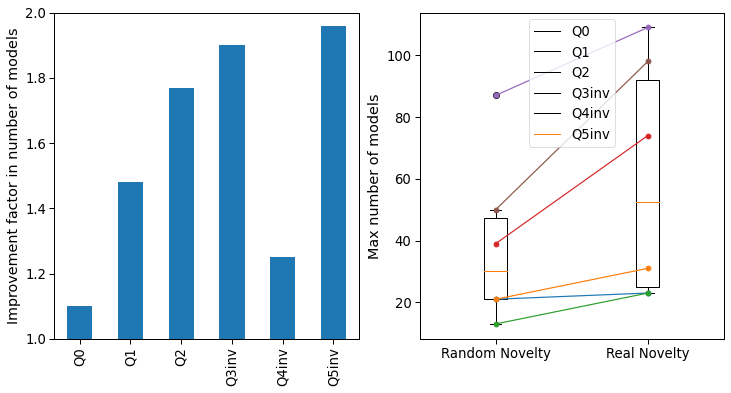

In [117]:
sns.set_context('paper', font_scale=1.5)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
maxmodel['factor'].plot.bar(ylim=[1, 2])
plt.ylabel('Improvement factor in number of models')

plt.subplot(1, 2, 2)
plt.xlim=[-1, 5]

# boxplot c1, c2
#maxmodel.boxplot(column=['numc1', 'numc2']) ---> gives index error
ax = plt.boxplot([ maxmodel['numc1'], maxmodel['numc2'] ], labels=['Random Novelty', 'Real Novelty'], notch=False)

# connect per user
plt.plot([1, 2], [ maxmodel['numc1'], maxmodel['numc2'] ], 'o-')

plt.xlim=[-1, 5]
plt.ylabel('Max number of models')
plt.legend(maxmodel.index, loc='best')

fig.savefig('fig/improvement.png')
fig.savefig('fig/improvement.pdf')

# Distribution of rewards

We check whether the distribution of rewards was more or less equivalent between the random and novelty condition, which would only leave the correlation between movement and rewards as an independent variable. In other words, there were no direect correlation between the movement performed by the participants and the rewards they received in the random condition.

<AxesSubplot:>

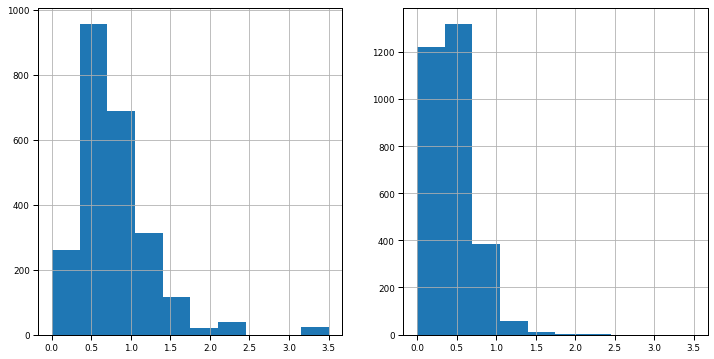

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
select(df, condition='c1')['random_novelty'].hist(ax=axs[0], range=(0, 3.5))
select(df, condition='c2')['min_dtw'].hist(ax=axs[1], range=(0, 3.5))

This empirical distribution could be modelled from the pilot data and used in a controlled experiment to increase the degree of similarity of the reward structure between both conditions random and novelty.

In [44]:
import scipy.stats as scsta

In [59]:
min_dtw = df['min_dtw']
threshold = df['threshold']
reward = min_dtw / threshold

In [56]:
res = scsta.gamma.fit(reward.dropna().values)

In [57]:
gamma_rv = scsta.gamma(*res)
x = np.linspace(0, 3)
y = gamma_rv.pdf(x)

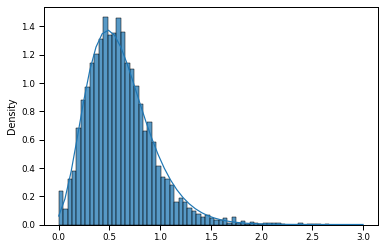

In [58]:
sns.set_context('paper', font_scale=1)
sns.histplot(reward, stat='density')
plt.plot(x, y)

# Evolution of averaged minimum DTW between segments

One of the adaptive parameters of our clustering approach is the averaged minimum DTW distance against which we decided whether a new segment should be qualified as a new model.

In [46]:
df.loc[df['threshold'] == 'False', 'threshold'] = 0

In [47]:
df['threshold'] = df['threshold'].astype(float)

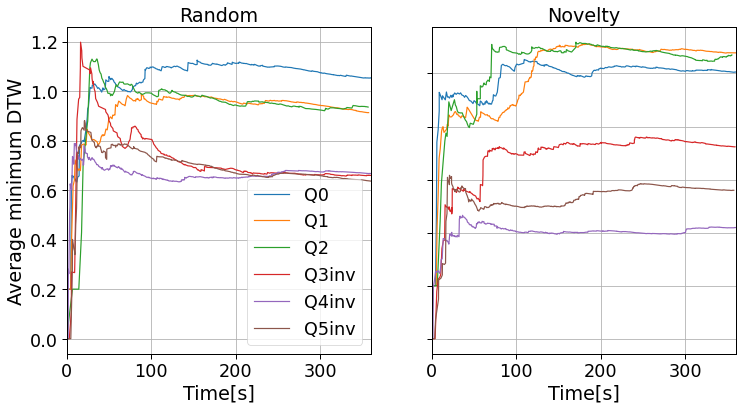

In [48]:
sns.set_context("paper", font_scale=2)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, grp in select(df, condition='c1').groupby('user'):
    grp['then'] -= grp['then'].iloc[0]
    grp['then'] /= 1000
    grp.plot('then', 'threshold', ax=axs[0], label=i)
    
for i, grp in select(df, condition='c2').groupby('user'):
    grp['then'] -= grp['then'].iloc[0]
    grp['then'] /= 1000
    grp.plot('then', 'threshold', ax=axs[1], label=i)

axs[0].set_title('Random')
axs[1].set_title('Novelty')

for ax in axs:
    ax.set_xlim([0, 360])
    # ax.set_ylim([0, 35])
    ax.set_xlabel('Time[s]')
    ax.set_ylabel('Average minimum DTW')
    ax.grid()

axs[1].get_legend().remove()
axs[1].set_ylabel('')
axs[1].set_yticklabels([]);

if False:
    fig.savefig('fig/avg_dtw_time.png')